# **Mushroom Classification - Playground Series**

The objectives of this notebooks are:

- Do an exploratory data analysis of missing data, categorical and numeric varibles.
- Propose a preprocessing steps from what we learn in the EDA.
- Model and tune models using tidymodels.

Since I am new to tidymodels this challenge is a great way to learn tidymodels potential.

<span style="color:crimson; font-size: 20px;">**Feedback is always welcome, this is my first Kaggle notebook!**</span>

### **Set-up**

I will load libraries, the data and other things to get ready to start.

In [1]:
options(scipen = 9999) # to avoid scientific annotation

# Suppress package startup messages for all libraries
suppressPackageStartupMessages({
  library(tidyverse)     # Classic library for data wrangling includes `dplyr`
  library(effectsize)    # To do cramers'V analysis 
  library(naniar)        # Missing data exploration package
  library(tidymodels)    # To model and tune
  library(bonsai)        # Extension of other learners such as lightgbm
  library(finetune)      # For tuning using Bayesian optimization
  library(future)        # For parallelization
  library(vip)           # To see variable importance
})

# To avoid conflicts between packages
tidymodels_prefer()


In [2]:
# To avoid progress and column revision
suppressMessages({
  suppressWarnings({
    train <- read_csv("Data/train.csv", progress = FALSE, show_col_types = FALSE)
    test <- read_csv("Data/test.csv", progress = FALSE, show_col_types = FALSE)
  })
})

# Correct column names to work in R
col_names <- colnames(train)
col_names <- gsub("-", "_", col_names)
colnames(train) <- col_names

col_names <- colnames(test)
col_names <- gsub("-", "_", col_names)
colnames(test) <- col_names
features <- train %>% select(-id, -class) %>% colnames()


In [30]:
# To improve visualization of the plots
my_theme <- function() {
  theme_bw() +
  theme(
    text = element_text(size = 20),
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 20),
    legend.text = element_text(size = 18),
    legend.title = element_text(size = 20),
    plot.title = element_text(size = 24),
  )
}

## **Missing Data Exploration**

From the discussions I could see that many of the variables have a lot of missing values. Lets analyze this with the `naniar` package.

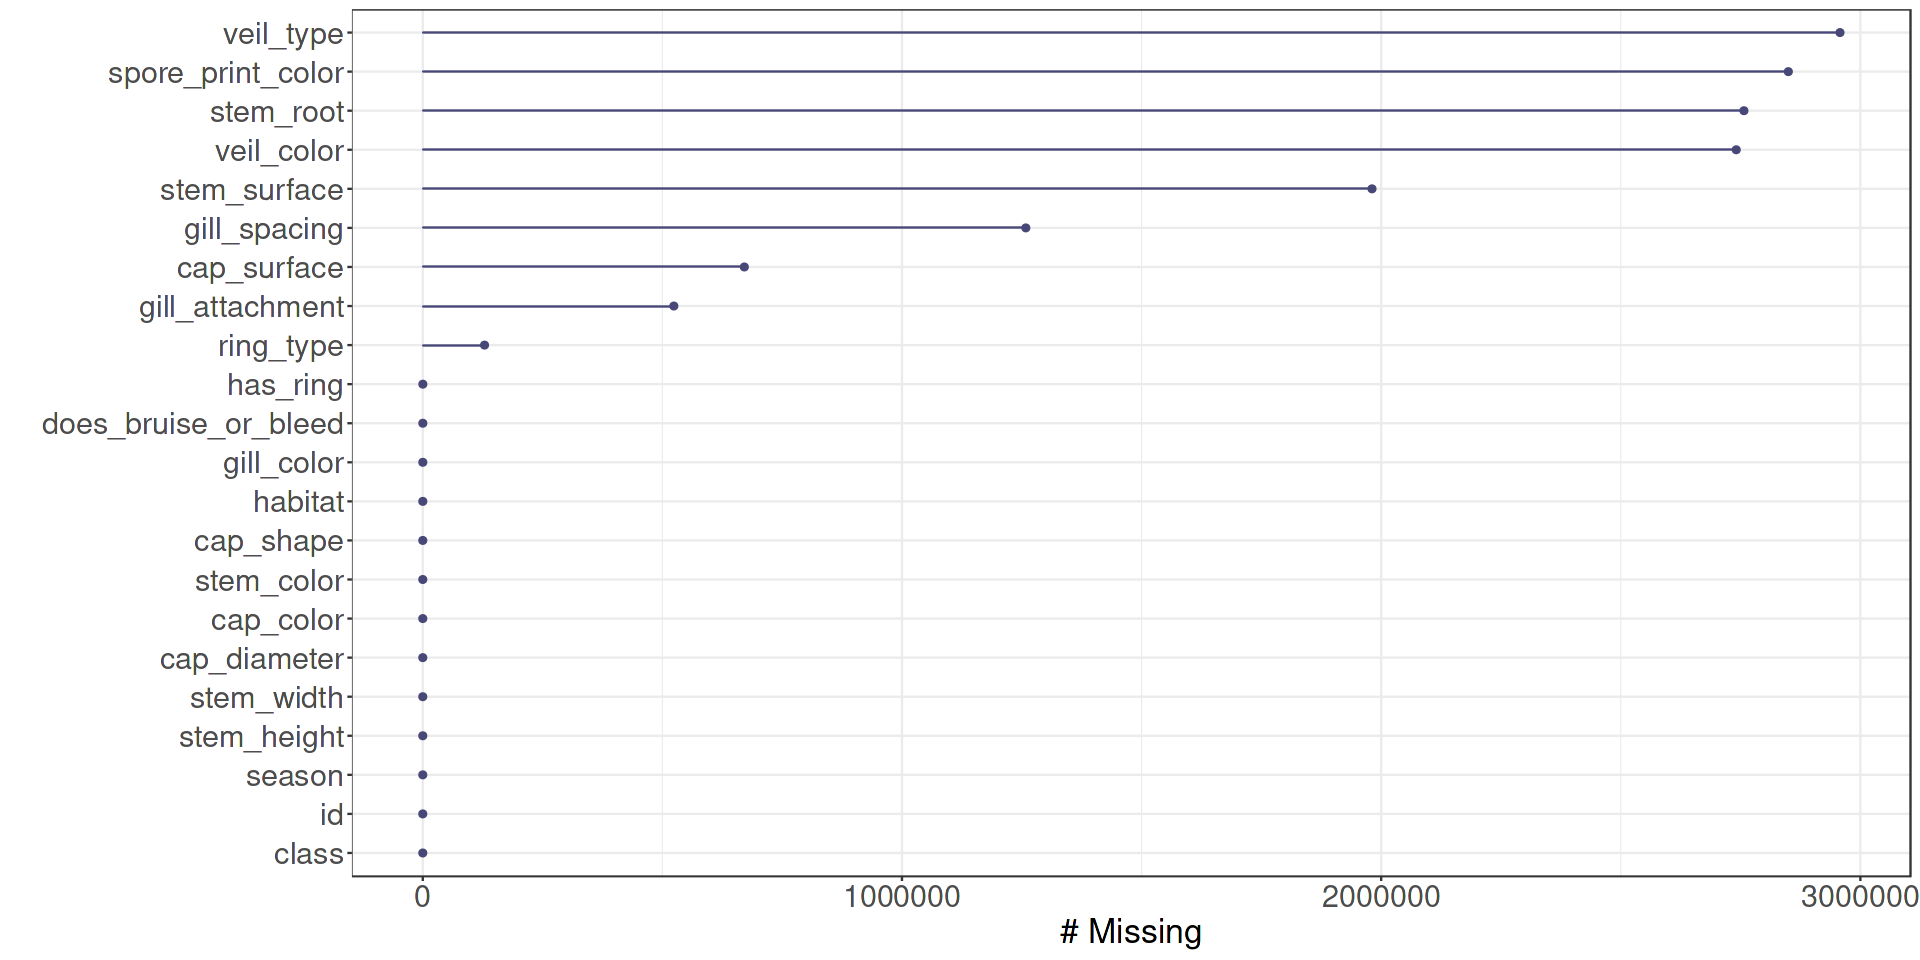

In [5]:
# Lets see missing data with naniar package
options(repr.plot.width=16, repr.plot.height=8)
gg_miss_var(train) + my_theme() + xlab("")

whats up with `veil_type`...

<span style="color:tomato; font-size: 20px;">**Is the missing data the same between train and test set?**</span>

In [9]:
# Missing data Train
# Columns with over 80% missing are: veil_color, stem_root, spore_print_color, veil_type
train_missing <- train %>% 
  map_df(is.na) %>% 
  map_df(sum) %>% 
  pivot_longer(cols = everything(), names_to = "features", values_to = "na_count") %>%
  mutate(pct = round(na_count/nrow(train),3)) %>% 
  arrange(desc(na_count)) 

# Missing data in Test
test_missing  <- test %>% 
  map_df(is.na) %>% 
  map_df(sum) %>% 
  pivot_longer(cols = everything(), names_to = "features", values_to = "na_count") %>%
  gather(features, na_count) %>% 
  mutate(pct = round(na_count/nrow(test),3)) %>% 
  arrange(desc(na_count)) 

# Proportion of missing data are identical between train and test
train_missing %>% 
  left_join(test_missing, by = "features", suffix = c("_train", "_test")) 

features,na_count_train,pct_train,na_count_test,pct_test
<chr>,<int>,<dbl>,<int>,<dbl>
veil_type,2957493,0.949,1971545,0.949
spore_print_color,2849682,0.914,1899617,0.914
stem_root,2757023,0.885,1838012,0.885
veil_color,2740947,0.879,1826124,0.879
stem_surface,1980861,0.636,1321488,0.636
gill_spacing,1258435,0.404,839595,0.404
cap_surface,671023,0.215,446904,0.215
gill_attachment,523936,0.168,349821,0.168
ring_type,128880,0.041,86195,0.041


In [10]:
# Whats up with veil_type? Almost 95% missing data
train %>% 
  count(veil_type) %>% 
  arrange(desc(n))  %>% 
  left_join(test %>% count(veil_type), by = "veil_type", suffix = c("_train", "_test"))

veil_type,n_train,n_test
<chr>,<int>,<int>
NA,2957493,1971545
u,159373,106373
w,11,12
a,9,2
e,8,6
f,8,NA
b,5,1
c,5,2
g,4,3


**Main ideas:**

- Mainly one value, there some rare values not present in test.
- Missing could be a category in this case

<span style="color:tomato; font-size: 20px;">**Does missing have a pattern?**</span>

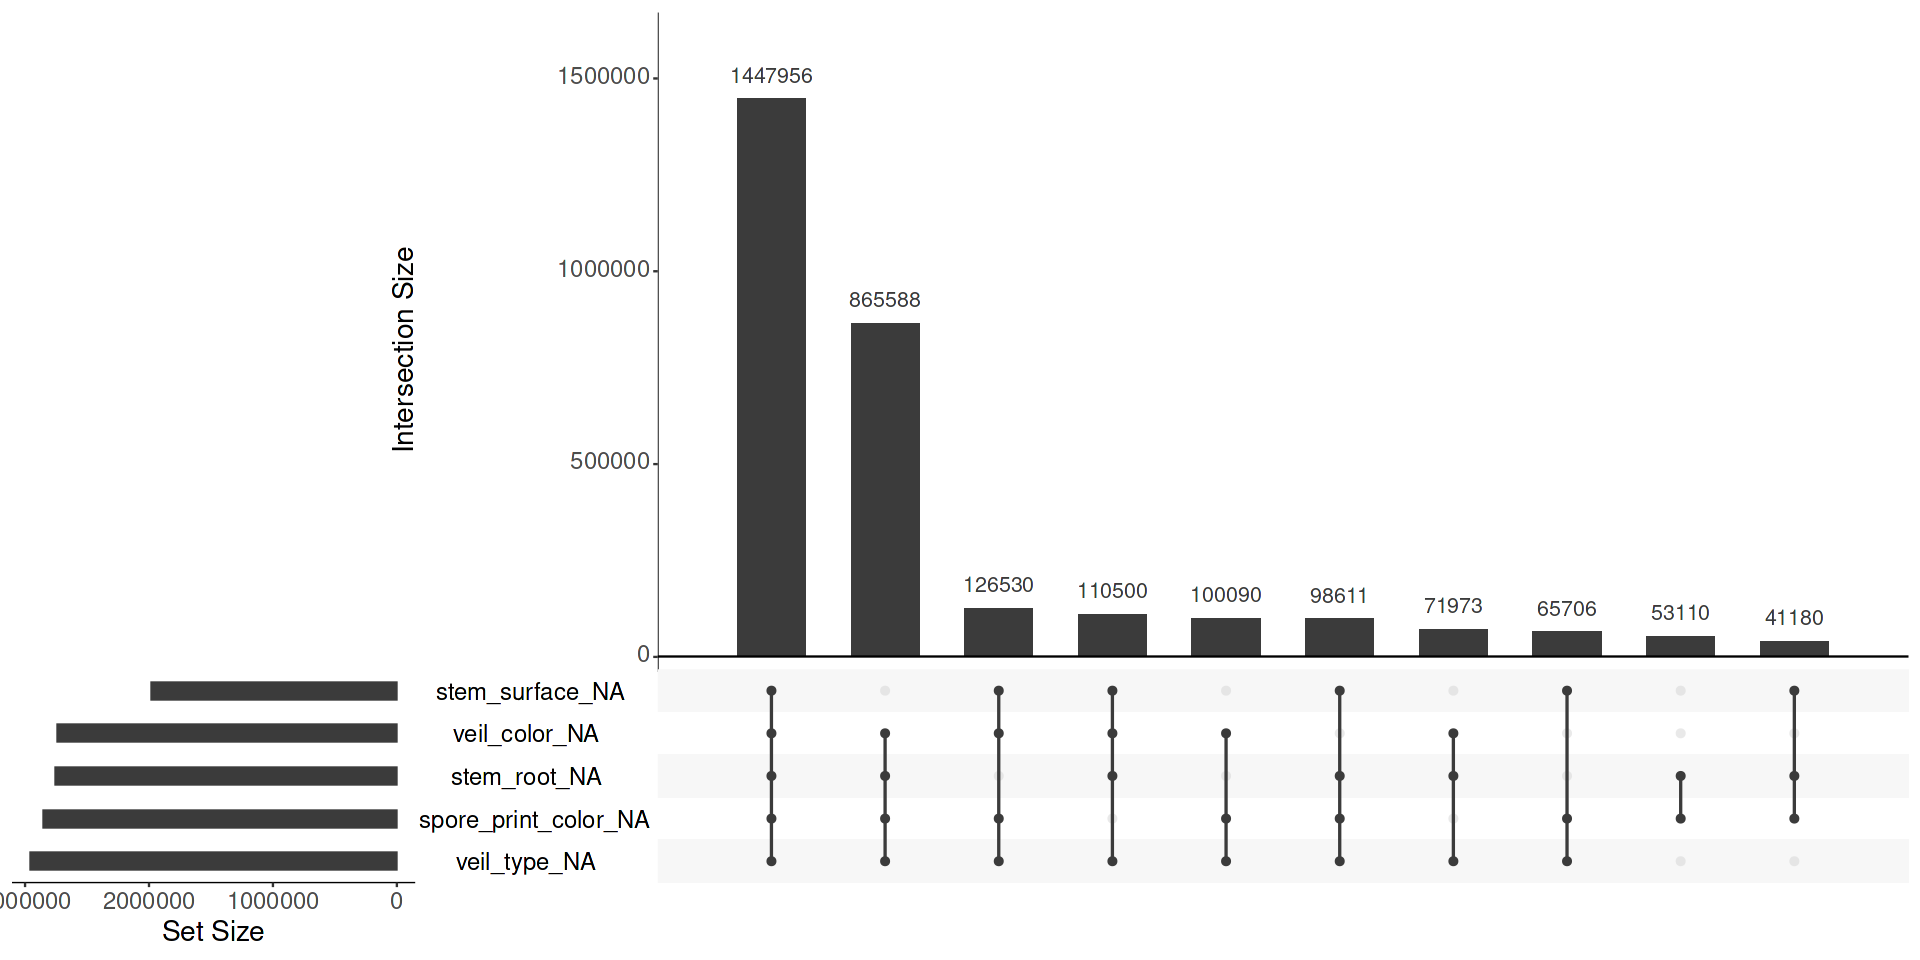

In [15]:
# Lets see an upset plot of train
gg_miss_upset(train, text.scale = 2, nsets=5, nintersects=10)

**Systematic missingness:**

- The high correlation in missingness among the top five variables suggests a systematic reason for this data being absent. 
- It could be due to data collection methods? certain types of mushrooms being harder to classify? or specific study designs.
- The top 5 variables with missing share almost 1.5 million rows. Then the almost 900K more rows with the following 4 top variables. 

<span style="color:tomato; font-size: 20px;">**Does missing data have any pattern with the Class?**</span>

In [17]:
# Lets generate a boolean dataframe that says true if it has missing data or false if it has data
train_bool <- train %>% 
  mutate_at(vars(all_of(features)), function(x) is.na(x))

# remove features iwht low amount of missing data, better visualization
relevant_feats_missing <- train_bool %>% 
  select(all_of(features)) %>% 
  summarise_all(sum) %>% 
  pivot_longer(cols = everything(), names_to = "feature", values_to = "is_missing") %>%
  filter(is_missing > 5) %>% pull(feature)

# The power of tidyverse and piping in this chunk of code
# I will quantify the absolute difference by column of the posionous proportion
# between those rows that have missing data or not.
results <- train_bool %>%
  select(id, class, all_of(relevant_feats_missing)) %>%
  gather(features, is_missing, all_of(relevant_feats_missing)) %>% # pivoting the dataframe
  group_by(features, is_missing) %>%
  # Calculate the proportion of poisonous mushrooms between missing and non missing values
  summarize(total = n(),
    poisonous = sum(class == "p"),
    prop_poisonous = poisonous / total,
    .groups = "drop")  %>% 
  group_by(features) %>%
  # Calculate the difference in proportion of poisonous mushrooms between missing and non missing values
  mutate(baseline = prop_poisonous[!is_missing], 
    abs_diff_from_baseline = abs(prop_poisonous - baseline)) %>% # absolute difference
  filter(is_missing) %>%  # Keep only the rows where is_missing is TRUE
  ungroup() %>%
  arrange(desc(abs(abs_diff_from_baseline)))  # Sort by absolute difference


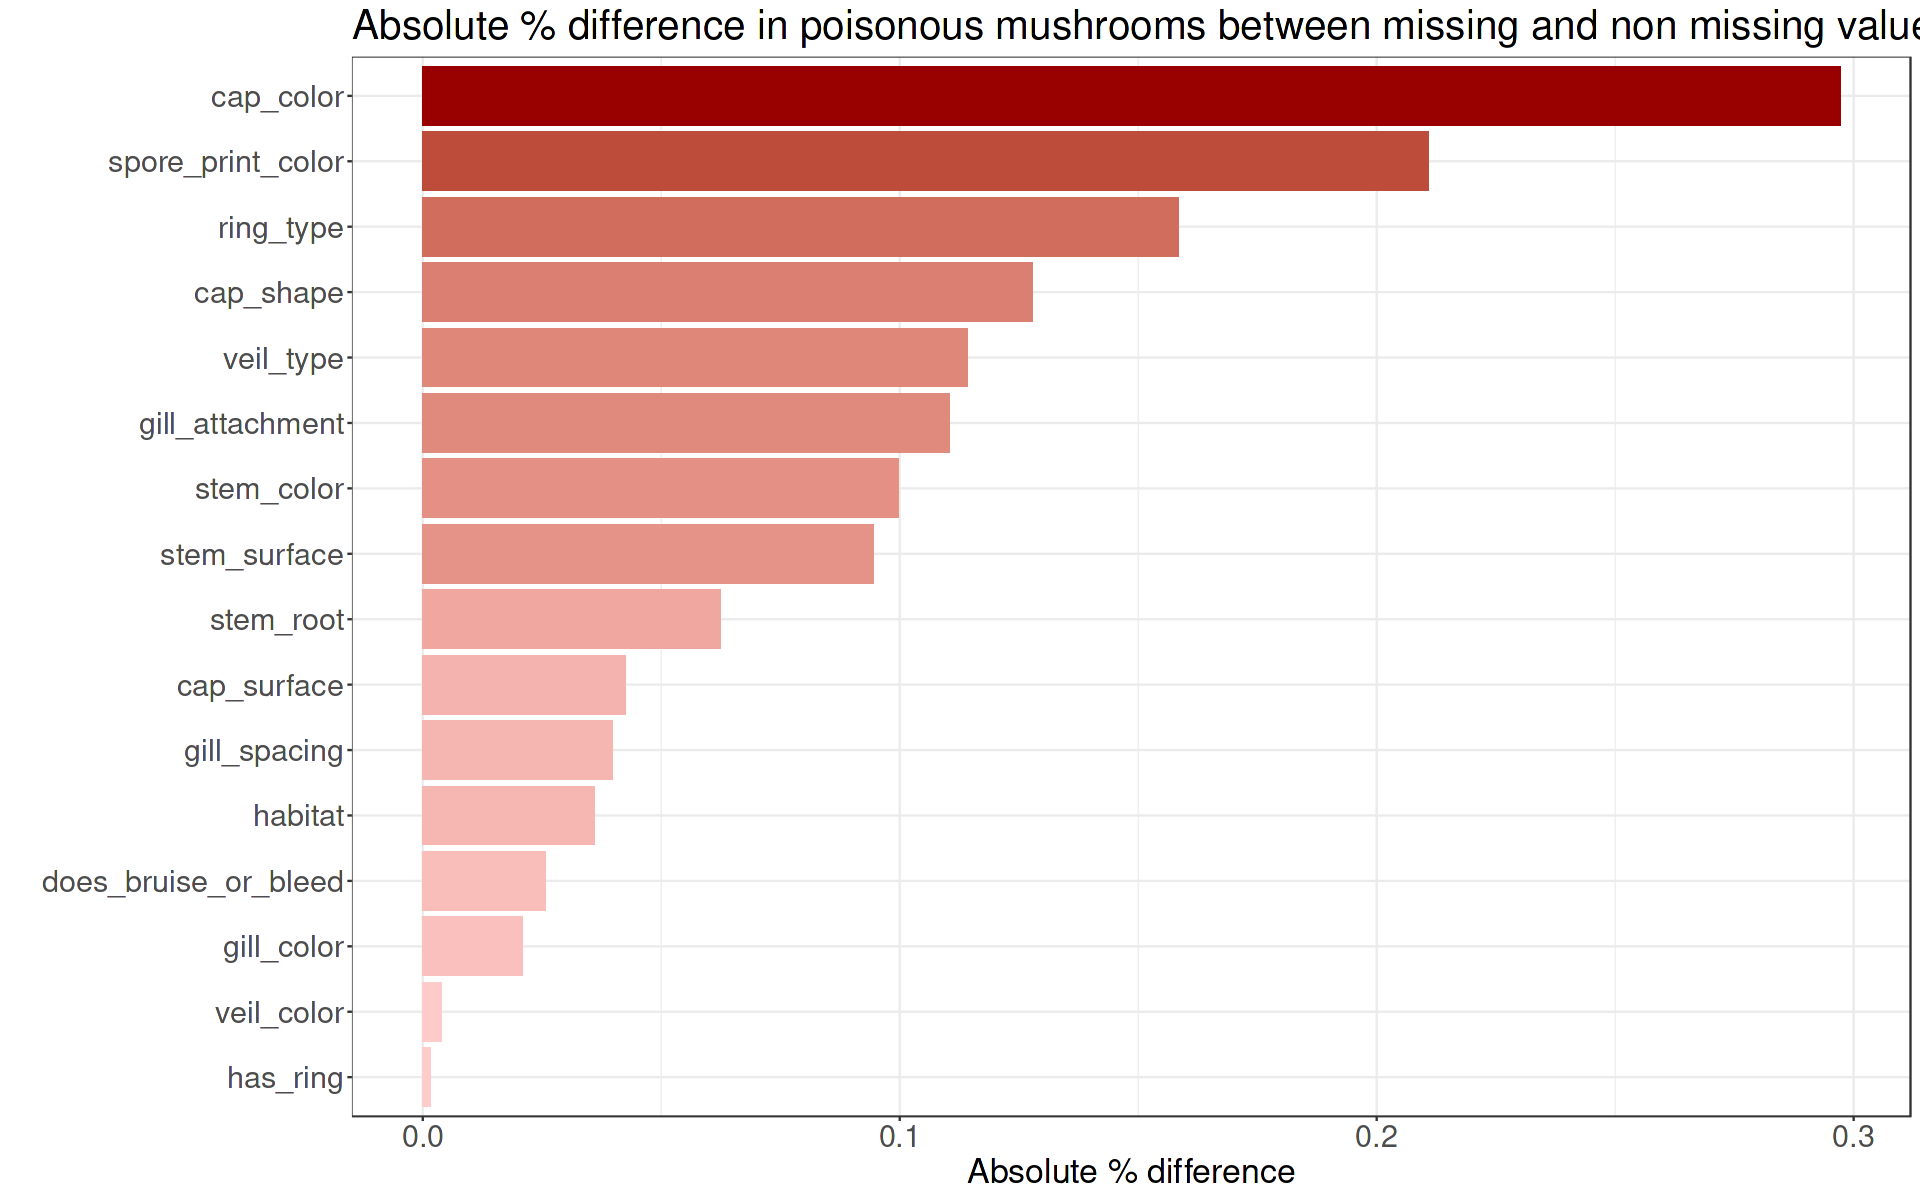

In [18]:
options(repr.plot.width=16, repr.plot.height=10)
results %>% 
  ggplot(aes(x = reorder(features, abs_diff_from_baseline), y = abs_diff_from_baseline, fill = abs_diff_from_baseline)) +
  geom_bar(stat = "identity", position = "dodge") +
  ylab("Absolute % difference") + xlab("") +
  scale_fill_gradient(low = "#FFCCCC", high = "#990000") +
  ggtitle("Absolute % difference in poisonous mushrooms between missing and non missing values") +
  coord_flip() +
  my_theme() +
  theme(legend.position = "none")

**Missing data is relevant:**

- `cap_color` has almost 30% difference between missing and non missing values. 
- `veil_color`and `has_ring` have barely any difference with respect non missing values. 
- This information is relevant when imputing, missing could be category of its own in high missing features. 

## **Distribution of numeric Variables**

Lets see more of the numeric values, which are just 3 columns.

In [20]:
num_features <- train %>% 
  select_if(is.numeric) %>% 
  select(-id) %>% colnames()

cat("The numeric values are:", num_features)

df_dist <- train %>% 
  select(all_of(num_features)) %>% 
  mutate(type = "train") %>% 
  bind_rows(test %>% # adding test data to compare
              select_if(is.numeric) %>% 
              mutate(type = "test")) %>% 
    pivot_longer(cols = cap_diameter:stem_width, names_to = "features", values_to = "values")

# See distribution
# There is a extreme value in test cap_diameter (>600)
df_dist %>% 
  group_by(type, features) %>% 
  summarise(min = min(values, na.rm = TRUE),
            p25 = quantile(values, 0.25, na.rm = TRUE),
            p50 = quantile(values, 0.50, na.rm = TRUE),
            mean = mean(values, na.rm = TRUE),
            p75 = quantile(values, 0.75, na.rm = TRUE),
            max = max(values, na.rm = TRUE), .groups = "drop") %>% 
  arrange(features)

The numeric values are: cap_diameter stem_height stem_width

type,features,min,p25,p50,mean,p75,max
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
test,cap_diameter,0.00,3.31,5.74,6.306192,8.23,607.00
train,cap_diameter,0.03,3.32,5.75,6.309848,8.24,80.67
test,stem_height,0.00,4.67,5.88,6.346509,7.41,57.29
train,stem_height,0.00,4.67,5.88,6.348333,7.41,88.72
test,stem_width,0.00,4.97,9.64,11.148374,15.62,102.91
train,stem_width,0.00,4.97,9.65,11.153785,15.63,102.90


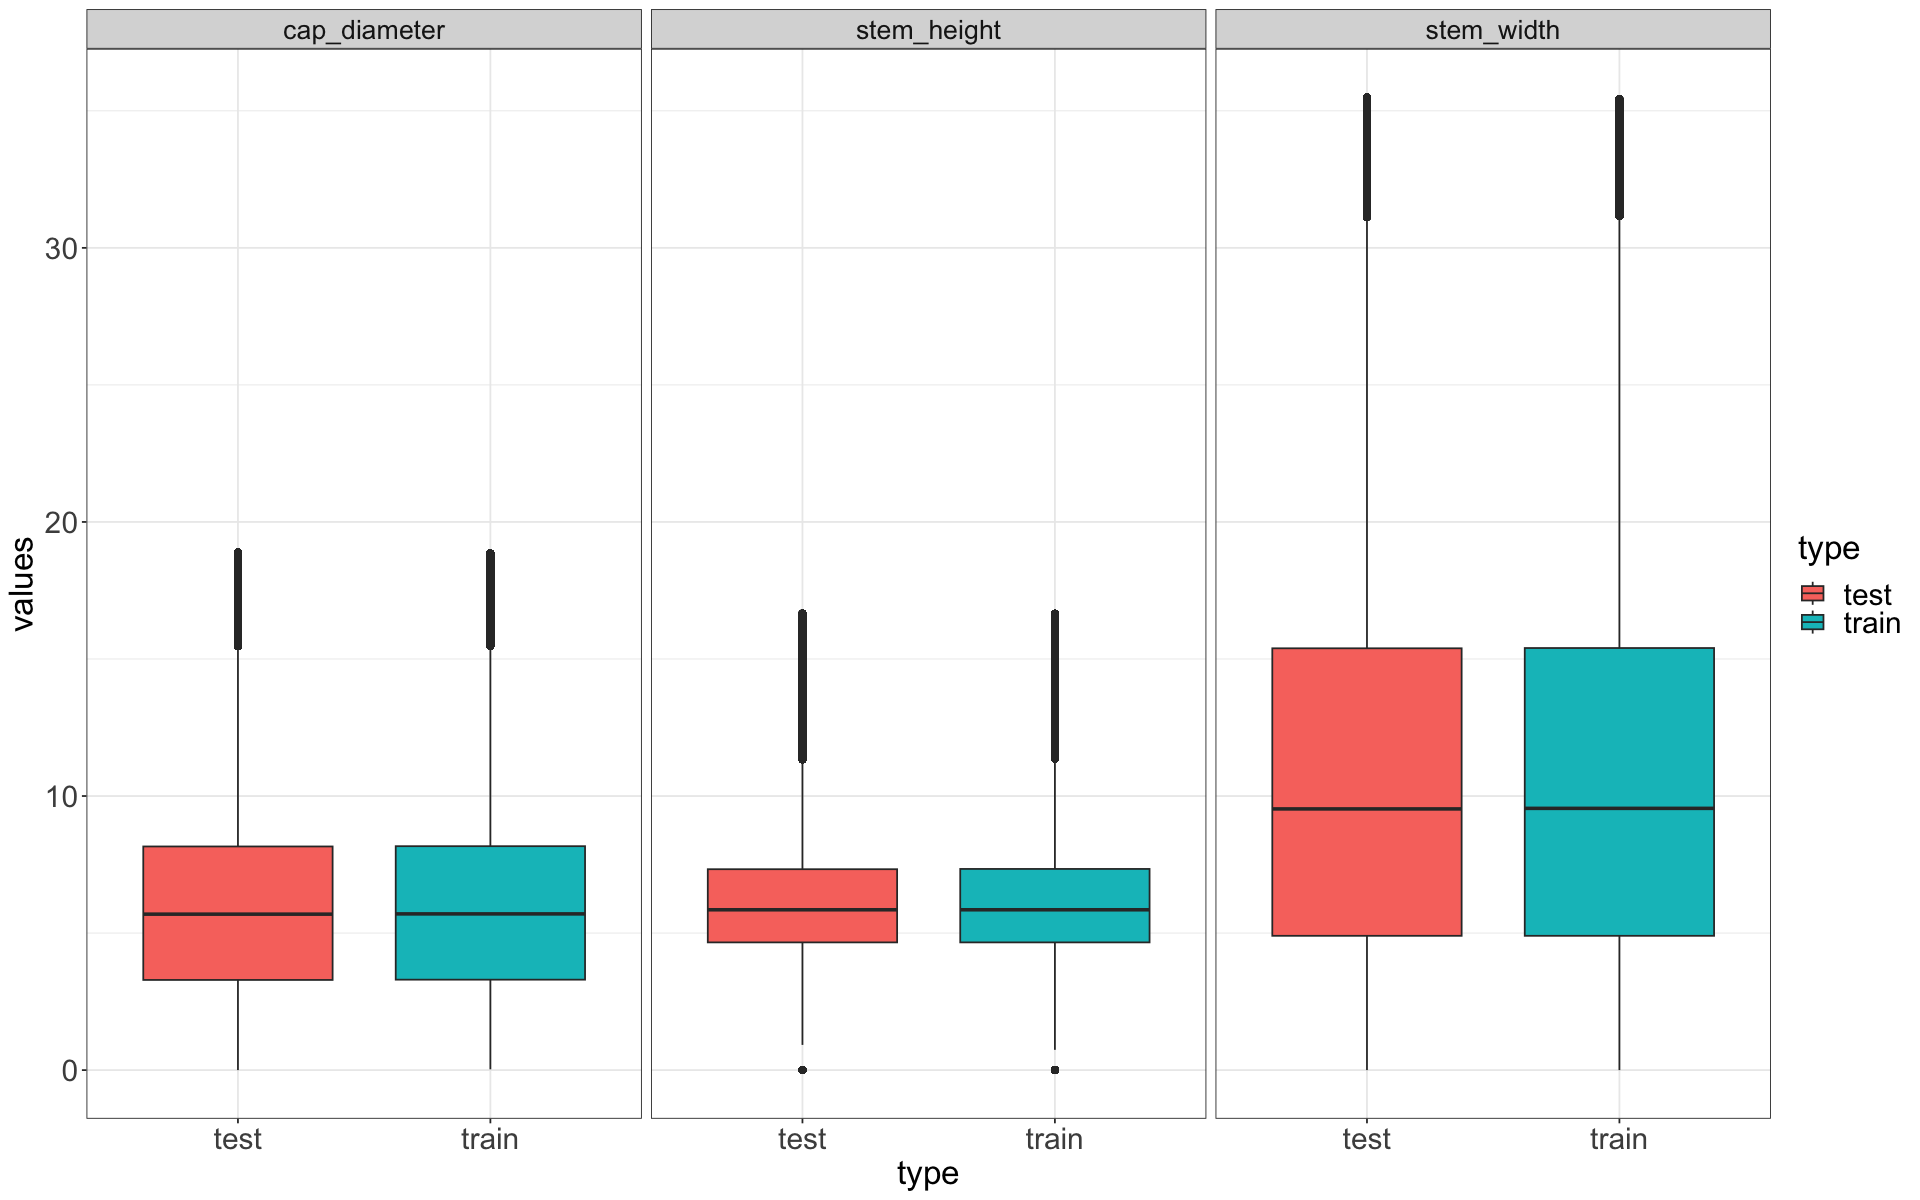

In [103]:
# Train and test distribution of numeric variables are almost identical
df_dist %>% 
  group_by(type, features) %>% 
  # Remove extreme ouliers
  filter(values < quantile(values, 0.99, na.rm = TRUE)) %>% 
  ungroup() %>% 
  ggplot(aes(x = type, y = values, fill = type)) +
  geom_boxplot() +
  facet_wrap(~features, ncol=3) +
  my_theme()

**Main ideas:**

- The distribution between train and test set of the numerical variables are identical. 
- The distributions are slightly negatively skewed (to the right), we could try a YeoJohnson transformation as preprocessing. 
- The data shows outliers, however `cap_diameter` has a extreme outlier.

## **Categorical Variables Exploration**

This is the hard part of the challenge in my opinion, so lets dive in. 

There seems to be a lot of values for each categorical features. I will analyze this by counting each value within a feature, and classifying each value into three types:

- Mayority Values that account for the 90% of the Feature.
- Minority that account for almost the 10% remaining.
- Rare that account for les than 0.1% 

In [21]:
cat_features <- train %>% 
  select_if(is.character) %>% 
  select(-class) %>% colnames()

cat("The categorical values are:", cat_features)

cat_counts <- train %>% # If you want to explore test set change dataset here
  select(all_of(cat_features)) %>% 
  pivot_longer(everything(), names_to = "features", values_to = "values") %>%
  group_by(features, values) %>% 
  summarise(n = n()) %>%
  filter(!is.na(values)) %>% # remove NA values from each feature
  arrange(desc(n)) %>% 
  mutate(pct = n/sum(n),
         cum_pct = cumsum(pct),
         type = case_when(
           pct > 0.05 ~ "Majority",
           between(pct, 0.001, 0.05) ~ "Minority",
           TRUE ~ "Rare"
         ))

The categorical values are: cap_shape cap_surface cap_color gill_attachment gill_spacing gill_color stem_root stem_surface stem_color veil_type veil_color ring_type spore_print_color habitat season

`summarise()` has grouped output by 'features'. You can override using the
`.groups` argument.


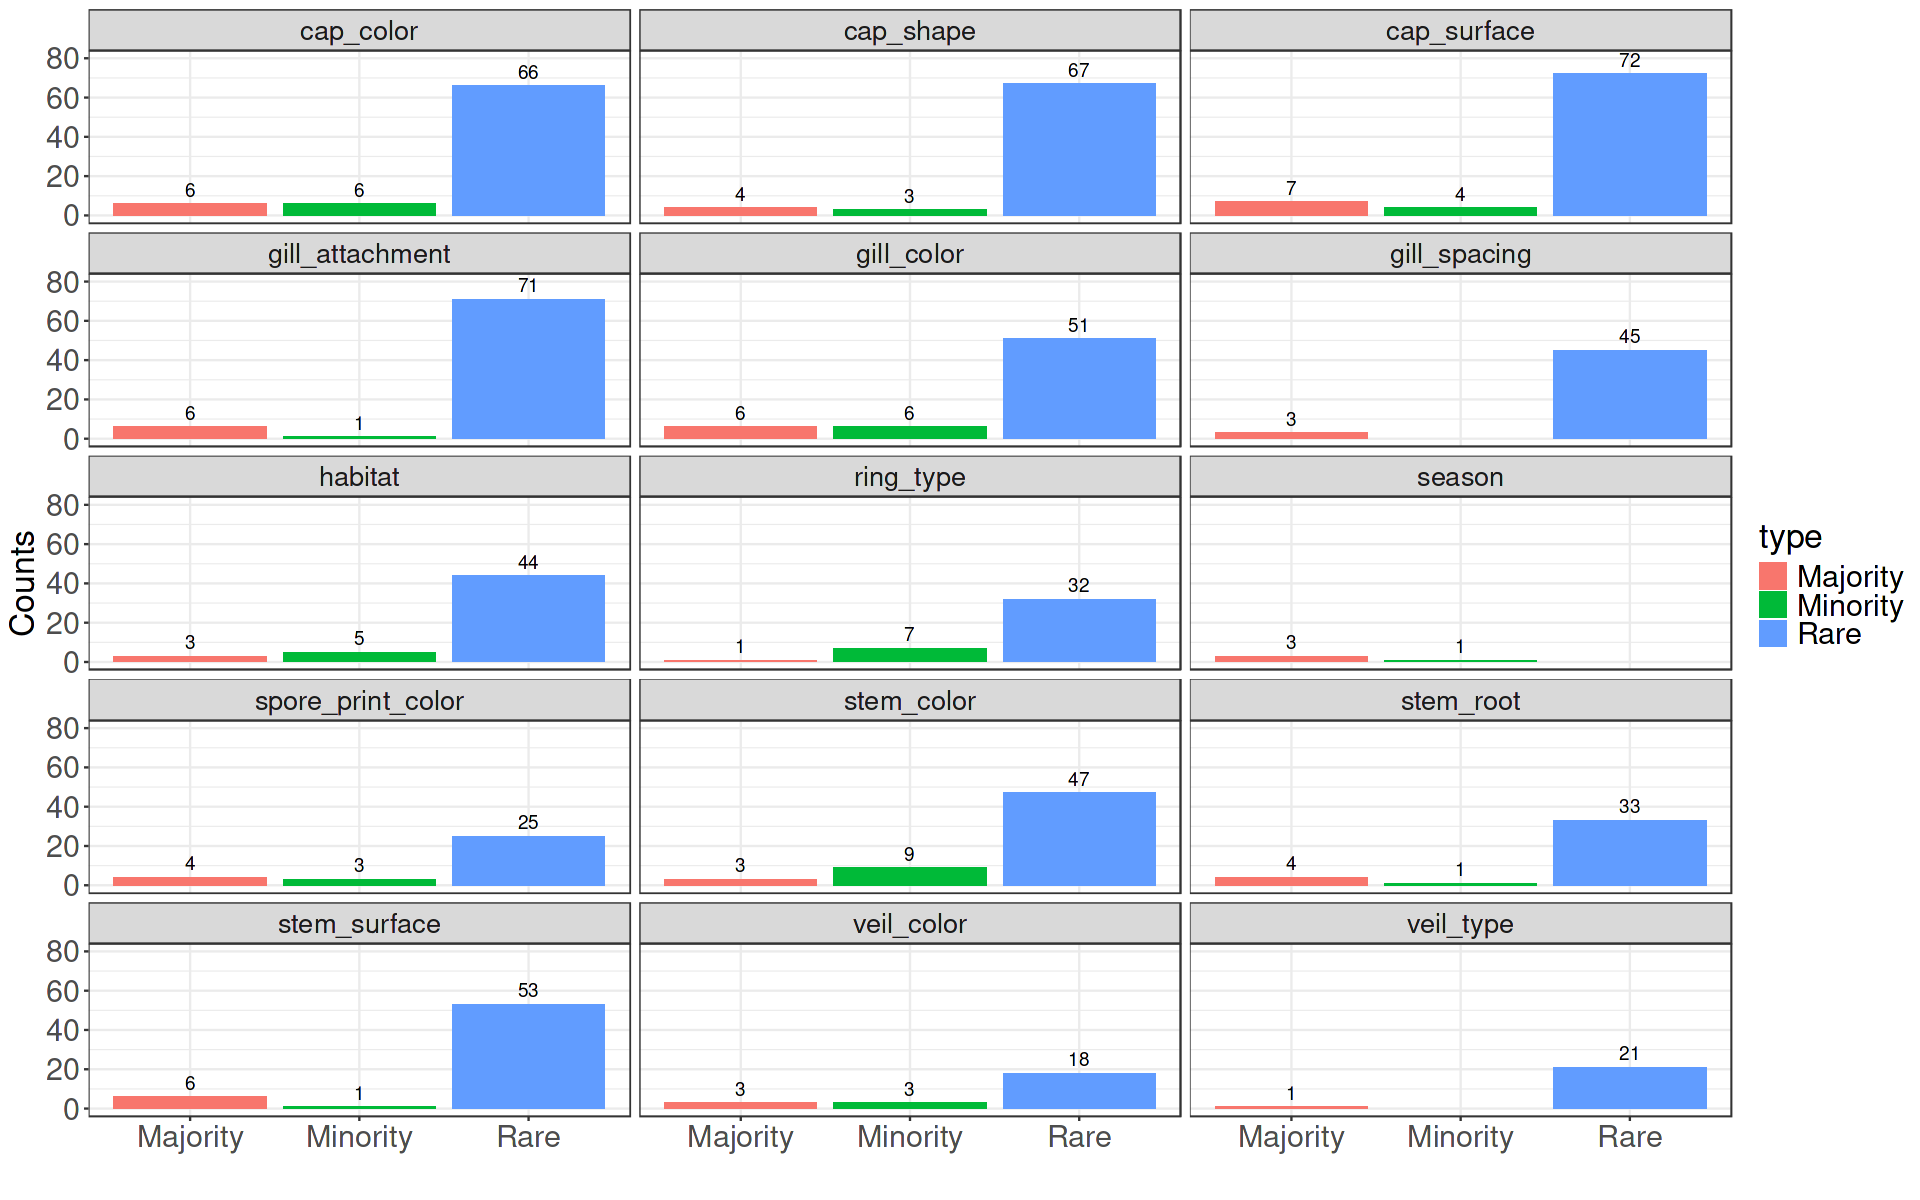

In [22]:
# Lets see all the categorical variables
cat_counts %>% 
  count(features, type) %>% 
  ggplot(aes(x = type, y = n, fill = type)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = n), vjust = -0.5) +
  facet_wrap(~features, ncol = 3) +
  my_theme() + ylim(c(0,80)) +
  xlab("") + ylab("Counts")

In [399]:
# Example of rare values for cap_surface
cat_counts %>% 
    filter(features == "cap_surface") # you can explore other features changing this filter

#cat_counts %>% filter(features == "stem_color")

features,values,n,pct,cum_pct,type
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
cap_surface,t,460777,0.1883858111583,0.1883858,Majority
cap_surface,s,384970,0.1573925906059,0.3457784,Majority
cap_surface,y,327826,0.1340296215497,0.4798080,Majority
cap_surface,h,284460,0.1162997021164,0.5961077,Majority
cap_surface,g,263729,0.1078239616799,0.7039317,Majority
cap_surface,d,206832,0.0845619770377,0.7884937,Majority
cap_surface,k,128875,0.0526897423548,0.8411834,Majority
cap_surface,e,119712,0.0489435067839,0.8901269,Minority
cap_surface,i,113440,0.0463792385857,0.9365062,Minority


**Important findings:**

- `Rare` types make of the mayority of the unique values for almost all of the categorical features.
- `Rare` types usually have less than 100 values. (Check other features above)
- `cap_surface`, `habitat` and `cap_shape` have around 70 unique rare values.
- Many of the rare values in cap_surface is just **garbage or noise**

What can we do with this?

<span style="color:tomato; font-size: 20px;">**Does the original dataset have this rare values?**</span>

This data set was created from an original much smaller dataset in the `ucimlrepo`. Lets look at some categorical variables from the original dataset. 

In [24]:
install.packages("ucimlrepo")
library(ucimlrepo)

# Fetch the Mushroom dataset
mushroom_data <- ucimlrepo::fetch_ucirepo(id = 848)
original_data <- mushroom_data$data$original %>% as_tibble() 

# Correct column names 
col_names <- colnames(original_data)
col_names <- gsub("-", "_", col_names)
colnames(original_data) <- col_names

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Comparing to the original dataset, most of the unique variables seen in train were just created, the original dataset doesn't have this rare values.

In [25]:
original_data %>% count(cap_surface, sort = TRUE)

cap_surface,n
<chr>,<int>
NaN,14120
t,8196
s,7608
y,6341
h,4974
g,4724
d,4432
e,2584
k,2303


I leave the analysis up to here, but there are still things you might do:

- Maybe removing all the values not present in the original columns as missing data.
- Creating a new category that groups all the values not present in the original dataset. 

<span style="color:tomato; font-size: 20px;">**Is this true for test set?**</span>

If we compare the train and test set, does this suffer from the same problems?

In [26]:
# Lets apply the same counting of rare values to the test set, lets combine the result in a clean table.
train_test_count <- train %>% 
  select(-class) %>%
  mutate(split = "train") %>%
  # adding test set to the mix
  bind_rows(test %>% mutate(split = "test"))  %>% 
  select(all_of(cat_features), split) %>% 
  pivot_longer(cols = -split, names_to = "features", values_to = "values")  %>%
  group_by(split, features, values) %>% 
  summarise(n = n()) %>%
  filter(!is.na(values)) %>% # remove NA values from each feature
  arrange(desc(n)) %>% 
  mutate(pct = n/sum(n),
         type = case_when(
           pct > 0.05 ~ "Majority",
           pct >= 0.001 ~ "Minority",
           TRUE ~ "Rare"
         )) 
  
  train_test_count  %>% 
  count(features, type)  %>% 
  pivot_wider(names_from = features, values_from = n)  %>% 
  arrange(type, split)


`summarise()` has grouped output by 'split', 'features'. You can override using
the `.groups` argument.


split,type,cap_color,cap_shape,cap_surface,gill_attachment,gill_color,gill_spacing,habitat,ring_type,season,spore_print_color,stem_color,stem_root,stem_surface,veil_color,veil_type
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
test,Majority,6,4,7,6,6,3,3,1,3,4,3,4,6,3,1
train,Majority,6,4,7,6,6,3,3,1,3,4,3,4,6,3,1
test,Minority,6,3,4,1,6,NA,5,7,1,3,9,1,1,3,NA
train,Minority,6,3,4,1,6,NA,5,7,1,3,9,1,1,3,NA
test,Rare,45,55,48,59,44,32,31,28,NA,26,43,26,47,17,14
train,Rare,66,67,72,71,51,45,44,32,NA,25,47,33,53,18,21


In [226]:
# Comparing train and test set majority features
train_test_count %>% 
    filter(type == "Minority", # change here to see other types
    features == "habitat") %>% # change here to see other features
    select(split, features, values, pct) %>%
    pivot_wider(names_from = split, values_from = pct) 

features,values,train,test
<chr>,<chr>,<dbl>,<dbl>
habitat,m,0.048435625,0.048730016
habitat,h,0.038543745,0.038515086
habitat,w,0.005945009,0.005930877
habitat,p,0.005511887,0.005500161
habitat,u,0.001688858,0.001652599


**For test set:**

- The majority features are identical between train and test set (explore above).
- The minority features are identical too.
- The rare features are different (noise)

<span style="color:tomato; font-size: 20px;">**Does these rare values have any predictive power?**</span>

Lets calculate chi-square statistic and Cramers'V by feature.

**chi-square statistic**: measures the association or independence between two categorical variables. When comparing a categorical feature to a target variable (often binary or categorical), the chi-squared statistic assesses whether the observed distribution of frequencies in the contingency table of the feature and the target significantly differs from what would be expected if the variables were independent. If the test is significant the feature and target variable are dependent (there is an association between them).

**Cramer's C**: measures the strength of the association between two categorical variables. While the chi-squared statistic tells you whether there’s an association, Cramér’s V quantifies how strong that association is.

In [29]:
# Step 1: Create encoding function
encode_categories <- function(data) {
  data %>%
    group_by(features, values) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(features) %>%
    mutate(
      total = sum(count),
      prevalence = count / total,
      type = case_when(
        prevalence > 0.05 ~ "Majority",
        prevalence > 0.001 ~ "Minority",
        TRUE ~ "Rare"
      )
    ) %>%
    select(features, values, count, type)
}

# Step 2: Create long dataset in train for categorical variables 
train_long <- train %>% 
    select(class, all_of(cat_features))  %>% 
    pivot_longer(cols = -class, names_to = "features", values_to = "values") %>% 
    filter(!is.na(values)) 

# Step 3: Apply encoding
encoded_categories <- train_long %>%
  encode_categories()

# Step 4: Join encoded categories with original data
encoded_data <- train_long %>%
  left_join(encoded_categories, by = c("features", "values"))

# We were able to generate a long table that for each feature we have its value, 
# the count, and the type define before. We also have the class that will allow us to 
# easily calculate the statistics. 
encoded_data %>% head()

class,features,values,count,type
<chr>,<chr>,<chr>,<int>,<chr>
e,cap_shape,f,676238,Majority
e,cap_surface,s,384970,Majority
e,cap_color,u,73172,Minority
e,gill_attachment,a,646034,Majority
e,gill_spacing,c,1331054,Majority
e,gill_color,w,931538,Majority


In [30]:
# Identify Features_Types with only 1 categorical variable
# The statistical test to follow can't handle 1 value of a categorical variable
remove_feature_types <- cat_counts %>% 
  count(features, type)  %>% 
  filter(n == 1) %>% 
  unite("features_type", features, type, sep = "_") %>% pull(features_type)

In [31]:
# Step 5: Apply Chi-Square test to identify relationship between categorical variables 
# Cramers V is a measure of association between two categorical variables
# Lowering sample size avoids over-signficance of chi-squared test
set.seed(40)
encoded_data %>%
  unite("features_type", features, type, sep = "_") %>%
  filter(!features_type %in% remove_feature_types) %>% 
  sample_n(1e6) %>% 
  group_by(features_type) %>%
  summarise(
    chi_square = chisq.test(table(values, class))$statistic, # Is there a relationship between the two categorical variables?
    p_value = round(chisq.test(table(values, class))$p.value, 4), # How likely is the relationship due to chance?
    significant = p_value < 0.05,
    cramers_v = cramers_v(table(values, class))$Cramers_v, # How strong is the relationship? 0 to 1
    .groups = "drop") %>%
  mutate(interpretation = case_when(cramers_v < 0.10 ~ "Negligible association",
                                    cramers_v < 0.20 ~ "Weak association",
                                    cramers_v < 0.40 ~ "Moderate association",
                                    cramers_v < 0.60 ~ "Relatively strong association",
                                    cramers_v < 0.80 ~ "Strong association",
                                    cramers_v <= 1.00 ~ "Very strong association",
                                    TRUE ~ "Invalid Cramer's V")) %>%
  arrange(desc(cramers_v))

Warning message:
“There were 30 warnings in `summarise()`.
The first warning was:
ℹ In argument: `chi_square = chisq.test(table(values, class))$statistic`.
ℹ In group 3: `features_type = "cap_color_Rare"`.
Caused by warning in `chisq.test()`:
! Chi-squared approximation may be incorrect
ℹ Run `dplyr::last_dplyr_warnings()` to see the 29 remaining warnings.”


features_type,chi_square,p_value,significant,cramers_v,interpretation
<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>
spore_print_color_Minority,656.565035,0.0000,TRUE,0.98841310,Very strong association
stem_color_Rare,23.466667,0.0014,TRUE,0.72418537,Strong association
veil_color_Rare,6.000000,0.1116,FALSE,0.70710678,Strong association
stem_surface_Rare,21.827957,0.0257,TRUE,0.55607665,Relatively strong association
stem_root_Majority,3691.324559,0.0000,TRUE,0.53134484,Relatively strong association
cap_color_Minority,3322.627446,0.0000,TRUE,0.48054132,Relatively strong association
ring_type_Minority,4141.253268,0.0000,TRUE,0.47472799,Relatively strong association
cap_shape_Rare,17.393519,0.1354,FALSE,0.44368425,Relatively strong association
veil_color_Majority,2099.426768,0.0000,TRUE,0.41644572,Relatively strong association


**Main ideas:**

- Most of the groupings by feature are relevant by chi-squared statistic, however this is expected due to the large sample size. 
- Cramers'V comes to the rescue which focuses on the effect size, some of the rare groupings have strong association.
- Some rare groupings relevant to notice are `stem_color_Rare`, `stem_surface_Rare`, `veil_color_Rare`.
- The rest of the rare grouping are not significant or relevant from cramers'V View. 

We can keep analyzing this from other measurements, one that is more common in the information value and weight of evidence. 

- **Information value**: measures the predictive power of a feature in binary classification problems. It evaluates how well a feature differentiates between the two classes of the target variable.
- **Relationship to WOE**: IV is based on the Weight of Evidence (WOE), which measures the strength of association between each category of a feature and the target outcome. WOE is calculated for each bin or category of a feature, and IV aggregates these values into a single score to indicate the feature’s overall predictive power.

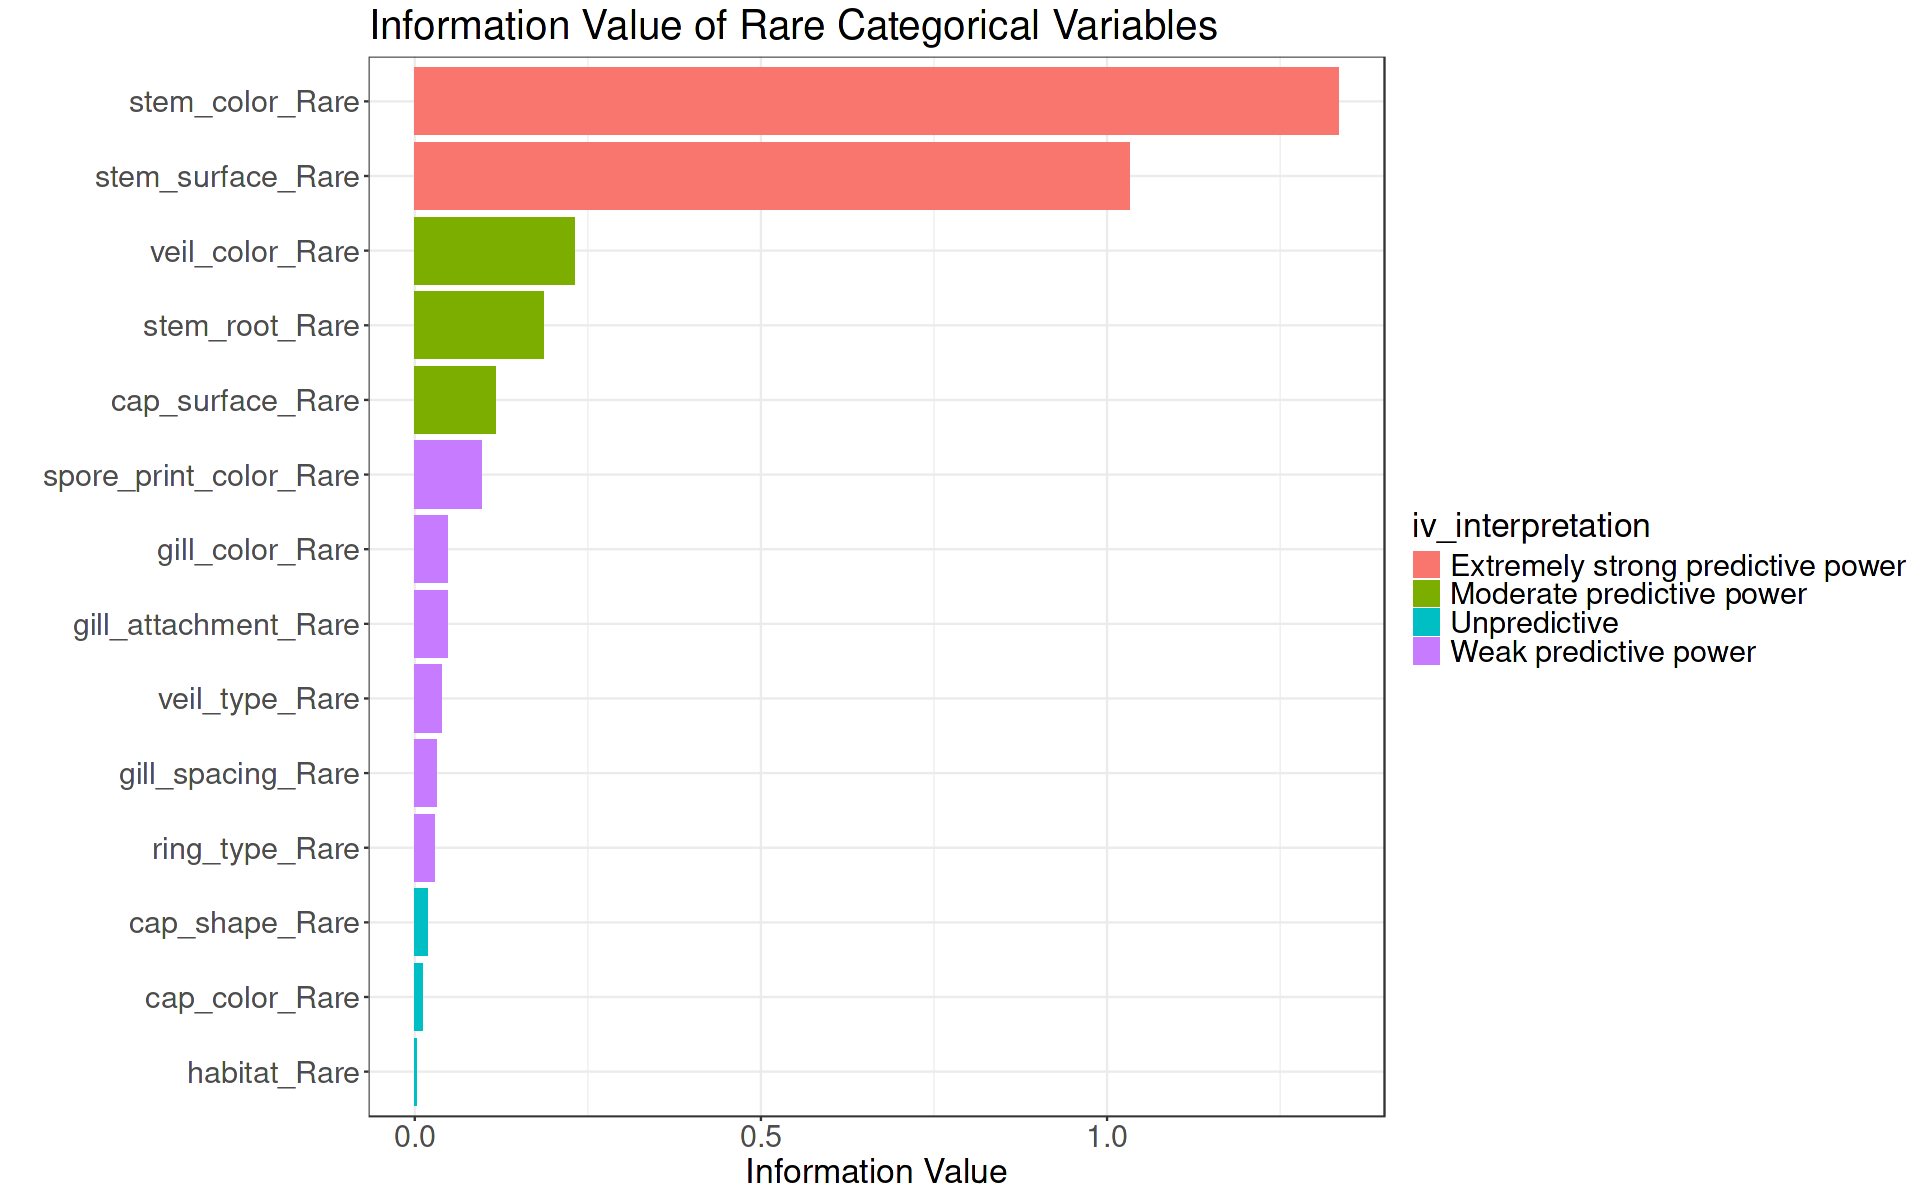

In [32]:
# Lets check with information value and weight of evidence
iv_data <- encoded_data %>%
    filter(type == "Rare") %>%
    unite("features_type", features, type, sep = "_")  %>% 
    count(features_type, class)  %>% 
    pivot_wider(names_from = class, values_from = n)   %>% 
    mutate(prop_p = p / (p + e), # proportion of poisonous mushrooms
           prop_e = e / (p + e), # proportion of edible mushrooms
           woe = log(prop_e / prop_p), # weight of evidence
           inf_value = (prop_e - prop_p) * woe)  %>% # information value
    arrange(desc(inf_value))  %>% 
    mutate(iv_interpretation = case_when(inf_value < 0.02 ~ "Unpredictive",
                                          inf_value < 0.1 ~ "Weak predictive power",
                                          inf_value < 0.3 ~ "Moderate predictive power",
                                          inf_value < 0.5 ~ "Strong predictive power",
                                          inf_value >= 0.5 ~ "Extremely strong predictive power",
                                          TRUE ~ "Suspicious (potential overfitting)"))

iv_data %>% 
       ggplot(aes(x = reorder(features_type, inf_value), y = inf_value, fill = iv_interpretation)) +
       geom_bar(stat = "identity") +
       coord_flip() +
       xlab("") + ylab("Information Value") +
       ggtitle("Information Value of Rare Categorical Variables") +
       my_theme() 

**Main ideas**:

- Information value on the rare groupings confirm what we did above that `stem_color_Rare`, `stem_surface_Rare`, `veil_color_Rare` are relevant to the problem. 
- So in the end its **not recommendable to throw away rare values at least for these features.**

# **Preprocessing: Collapsing categorical variables**

I will collapse rare values to a placeholder called `rare` as I did above using a prevalence of 0.1%, this criteria will apply for test set too. 

In [3]:
cat_features <- train %>% 
  select_if(is.character) %>% 
  select(-class) %>% colnames()

# Step 1: Create a function to identify rare categories
identify_rare_categories <- function(data, feature, threshold = 0.001) {
  data %>%
    count(!!sym(feature)) %>%
    mutate(
      total = sum(n),
      prevalence = n / total) %>%
    filter(prevalence >= threshold) %>%
    pull(!!sym(feature))
}

# Step 2: Create a function to replace rare categories with "rare"
replace_rare_categories <- function(data, feature, threshold = 0.001) {
  non_rare <- identify_rare_categories(data, feature, threshold)
  data %>%
    mutate(!!sym(feature) := if_else(!!sym(feature) %in% non_rare, 
                                     !!sym(feature), 
                                     "rare"))
}

# Step 3: Apply the transformation to all categorical variables in the training set
# The reduce function in Step 3 Applies the replace_rare_categories function to each categorical feature in turn
# The result is a dataset where all rare categories (prevalence < 0.001) in all categorical variables have been replaced with "Rare"
train_collapsed <- cat_features %>%
  reduce(function(data, feature) replace_rare_categories(data, feature), .init = train)

# Step 4: Apply the transformation to all categorical variables in the test set
test_collapsed <- cat_features %>%
  reduce(function(data, feature) replace_rare_categories(data, feature), .init = test)

# Lets check if the rare values are now "rare"
train_collapsed %>% 
  count(stem_color) %>% 
  arrange(desc(n)) %>% 
  full_join(test_collapsed %>% count(stem_color), by = "stem_color")

stem_color,n.x,n.y
<chr>,<int>,<int>
w,1196637,797365
n,1003464,668156
y,373971,250141
g,132019,88202
o,111541,75094
e,103373,68804
u,67017,44784
p,54690,36356
k,33676,22176


# **Preprocessing: Imputing missing values**

In this first submission I will just create a `Missing` category for categorical variables and for numerical variables impute the median. For logical columns will convert them to integer. 

In [4]:
impute_missing <- function(data) {
  # Identify numeric and categorical columns
  num_cols <- data %>% select_if(is.numeric) %>% names()
  cat_cols <- data %>% select_if(is.character) %>% names()
  
  # Calculate median for numeric columns
  medians <- data %>% summarise(across(all_of(num_cols), ~median(.x, na.rm = TRUE)))
  
  # Impute missing values
  data %>%
    mutate(across(all_of(num_cols), ~replace_na(.x, medians[[cur_column()]]))) %>%
    mutate(across(all_of(cat_cols), ~replace_na(.x, "Missing")))
}

# Apply to train data
train_imputed <- train_collapsed %>% 
  mutate_if(is.logical, as.integer) %>%
  impute_missing()

# Apply to test data
test_imputed <- test_collapsed %>% 
  mutate_if(is.logical, as.integer) %>%
  impute_missing()

In [5]:
# Example of veil type for train and test 
train_imputed %>% 
    count(veil_type) %>% 
    left_join(test_imputed %>% count(veil_type), by = "veil_type", suffix = c("_train", "_test"))

veil_type,n_train,n_test
<chr>,<int>,<int>
Missing,2957493,1971545
rare,79,46
u,159373,106373


# **Modeling: Tunning with TidyModels**

In [7]:
# Lets start by preparing the target as passing characters as factors
train_ready <- train_imputed %>% 
  mutate(class = as.factor(as.integer(class == 'p'))) %>%
  mutate_if(is.character, as.factor) 

test_ready <- test_imputed %>% 
  mutate_if(is.character, as.factor)

write_csv(train_ready, "Data/train_ready_1s.csv")
write_csv(test_ready, "Data/test_ready_1s.csv")

In [9]:
# 1. Split the data
data_split <- initial_split(train_ready, prop = 0.7)
train_data <- training(data_split)
val_data <- testing(data_split)

In [10]:
# 2. Define a recipe with more preprocessing steps
# Remove the id column
# Apply YeoJohnson transformation to numeric variables (try to normalize)
# step_novel creates a specification of a recipe step that will assign a previously unseen factor level to "new".
# step_zv creates a specification of a recipe step that will remove variables that contain only a single value (just in case)
recipe_no_encoding <- recipe(class ~ ., data = train_data) %>%
  step_rm(id) %>%
  step_YeoJohnson(all_numeric_predictors())%>%
  step_novel(all_nominal_predictors())%>%
  step_zv()

In [11]:
# 3. Define the LightGBM model with tunable parameters
lightgbm_model_tune <- boost_tree(
  trees = tune(),
  tree_depth = tune(),
  min_n = tune(),
  sample_size = tune(),
  mtry = tune(),
  learn_rate = tune()
) %>%
  set_engine("lightgbm",
            is_unbalance = TRUE,
            early_stop = 50) %>%
  set_mode("classification")


If your are wondering why I create a workflow set if I have one recipe and one model, is because I experimentes with multiple recipes and other models, but for simplicity of this notebook I reduce everything to the best combination. 

In [12]:
# 4. Create a workflow set 
workflow_exp <- workflow_set(
  preproc = list(no_encoding = recipe_no_encoding),
  models = list(lightgbm = lightgbm_model_tune),
)

In [13]:
# 5. Define the resampling method
cv_folds <- vfold_cv(train_data, v = 5, strata = class)

# 6. Define metrics
metrics <- metric_set(mcc) # The Matthews correlation coefficient (MCC).


In [14]:
# 7. Define the parameter space
lgb_params <- parameters(
  trees(range = c(300, 2000)),
  tree_depth(range = c(3, 8)),
  learn_rate(range = c(-4, -1), trans = log10_trans()),
  min_n(range = c(30, 1000)),
  sample_size = sample_prop(range = c(0.4, 1)),
  mtry(range = c(5,21))
)

In [15]:
# 8. Set up Bayesian optimization for tunning
bo_ctrl <- control_bayes(
  no_improve = 20,
  time_limit = 3600,
  verbose = TRUE,
  verbose_iter = TRUE
)

In [16]:
# 9. Set parallel processing
plan(multisession, workers = 8)
options(future.globals.maxSize = 16 * 1e9) # 30GB available

In [17]:
# 10. Tune the workflows using Bayesian optimization
tuned_workflows <- workflow_exp %>%
  workflow_map(
    fn = "tune_bayes",
    resamples = cv_folds,
    iter = 100,  # Increased due to more parameters
    initial = 10,  # Increased due to more parameters
    metrics = metrics,
    control = bo_ctrl,
    param_info = lgb_params
  )




>  Generating a set of 10 initial parameter results

v Initialization complete



Optimizing mcc using the expected improvement



-- Iteration 1 -----------------------------------------------------------------



i Current best:		mcc=0.9838 (@iter 0)

i Gaussian process model

! For the mcc estimates, 1 missing value was found and removed before fitting
  the Gaussian process model.

v Gaussian process model

i Generating 5000 candidates

i Predicted candidates

i trees=1500, tree_depth=4, learn_rate=0.00833, min_n=780, sample_size=0.595,
  mtry=10

i Estimating performance

i Fold1: preprocessor 1/1

v Fold1: preprocessor 1/1

i Fold1: preprocessor 1/1, model 1/1

v Fold1: preprocessor 1/1, model 1/1

i Fold1: preprocessor 1/1, model 1/1 (extracts)

i Fold1: preprocessor 1/1, model 1/1 (predictions)

i Fold2: preprocessor 1/1

v Fold2: preprocessor 1/1

i Fold2: preprocessor 1/1, model 1/1

v Fold2: preprocessor 1/1, model 1/1

i Fold2: preprocessor 1/1, model 1/1 (extracts)

i Fo

# **Modeling: Selecting best Models**

In [19]:
# Extract top 3 models for each recipe
top_3_per_recipe <- tuned_workflows %>%
  rank_results(rank_metric = "mcc") %>%
  filter(.metric == "mcc") %>%
  select(wflow_id, .config, mcc = mean, std_err, n) %>%
  slice_head(n = 3)
top_3_per_recipe

wflow_id,.config,mcc,std_err,n
<chr>,<chr>,<dbl>,<dbl>,<int>
no_encoding_lightgbm,Iter2,0.9843832,0.00008761064,5
no_encoding_lightgbm,Iter10,0.9843488,0.00007806573,5
no_encoding_lightgbm,Iter11,0.9843019,0.00010045504,5


In [20]:
# Top 3 models no_encoding parameters
tuned_workflows %>%
  extract_workflow_set_result("no_encoding_lightgbm") %>%
  show_best(metric = "mcc", n = 3)

trees,tree_depth,learn_rate,min_n,sample_size,mtry,.metric,.estimator,mean,n,std_err,.config,.iter
<int>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
1647,5,0.09267384,30,0.6574415,5,mcc,binary,0.9843832,5,0.00008761064,Iter2,2
1213,7,0.09616820,547,0.5236310,6,mcc,binary,0.9843488,5,0.00007806573,Iter10,10
1256,6,0.06802158,708,0.4364409,6,mcc,binary,0.9843019,5,0.00010045504,Iter11,11


In [21]:
# Extracting workflows and training on all train_data
fitted_no_encoding_models <- tuned_workflows %>%
  extract_workflow_set_result("no_encoding_lightgbm") %>%
  show_best(metric = "mcc", n = 3) %>% 
  select(trees:mtry, .config) %>% 
  group_split(row_number())  %>% # split into rows 
  map(function(x) {
    tuned_workflows %>%
      extract_workflow("no_encoding_lightgbm") %>%
      finalize_workflow(x) %>% 
      fit(data = train_data)
  })

In [24]:
# Evaluating final models on Validation Set
predictions_df <- val_data %>% 
    select(id, class) %>% 
    bind_cols("no_encode1_preds" = predict(fitted_no_encoding_models[[1]], val_data, type = "prob")$.pred_1) %>% 
    bind_cols("no_encode2_preds" = predict(fitted_no_encoding_models[[2]], val_data, type = "prob")$.pred_1) %>%
    bind_cols("no_encode3_preds" = predict(fitted_no_encoding_models[[3]], val_data, type = "prob")$.pred_1) %>% 
    as_tibble()

# Lets see the prediction dataframe
predictions_df %>% head(10)

id,class,no_encode1_preds,no_encode2_preds,no_encode3_preds
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
6,0,0.0005961123,0.0006947934,0.001079524
7,1,0.9981235117,0.9982164702,0.997410878
8,1,0.9958526363,0.9955210969,0.995330261
11,0,0.0037839561,0.0042663644,0.003517858
12,0,0.0123919490,0.0050988064,0.005751735
27,0,0.0016891659,0.0020259991,0.001554101
35,0,0.0044077703,0.0035812597,0.003985685
38,0,0.0089922438,0.0039219748,0.005889738
49,1,0.9957758817,0.9940238710,0.995030329


I am going try ensembling from bothe recipes to see if there is any gain.

In [26]:
# Lets generate ensembles of models from the two recipes
# Function to standardize probabilities
standardize_normalize_probs <- function(probs) {
  standardized <- (probs - mean(probs)) / sd(probs)
  normalized <- (standardized - min(standardized)) / (max(standardized) - min(standardized))
  return(normalized)
}

# Ensemble pair of no_encode and eff_encode
predictions_df <- predictions_df %>% 
  mutate_at(vars(ends_with("preds")), standardize_normalize_probs) %>% 
  mutate(ensemble_12_preds = (no_encode1_preds + no_encode2_preds)/2,
          ensemble_13_preds = (no_encode1_preds + no_encode3_preds)/2,
          ensemble_23_preds = (no_encode2_preds + no_encode3_preds)/2)


In [27]:
# Lets calculate the best threshold for each model
optimize_mcc_threshold <- function(truth, probability, step_size = 0.01) {
  # Create a dataframe with truth and probability
  df <- tibble(truth = truth, probability = probability)

  # Function to calculate MCC for a given threshold
  calc_mcc <- function(threshold) {
    predictions <- as.factor(if_else(df$probability >= threshold, 1, 0))
    mcc_vec(df$truth, predictions)
  }
  
  # Generate thresholds
  thresholds <- seq(0.1, 0.9, by = step_size)
  
  # Calculate MCC for each threshold
  mcc_values <- map_dbl(thresholds, calc_mcc)
  
  # Find the threshold that maximizes MCC
  best_threshold <- thresholds[which.max(mcc_values)]
  best_mcc <- max(mcc_values)
  
  # Return results
  list(
    best_threshold = best_threshold,
    best_mcc = best_mcc,
    mcc_curve = tibble(threshold = thresholds, mcc = mcc_values)
  )
}

# Function to apply optimal threshold and calculate metrics
evaluate_with_optimal_threshold <- function(truth, probability) {
  opt_result <- optimize_mcc_threshold(truth, probability)
  predictions <- as.factor(if_else(probability >= opt_result$best_threshold, 1, 0))
  
  tibble(
    optimal_threshold = opt_result$best_threshold,
    f1_score = f_meas_vec(truth, predictions),
    mcc = mcc_vec(truth, predictions),
    roc_auc = roc_auc_vec(truth, probability, event_level = "second")
  )
}

results <- predictions_df %>%
  select(-id, -class) %>%
  imap_dfr(~ evaluate_with_optimal_threshold(val_data$class, .x) %>%
             mutate(model = .y))
results %>% arrange(desc(mcc))

optimal_threshold,f1_score,mcc,roc_auc,model
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.44,0.9915591,0.9845746,0.9972792,ensemble_12_preds
0.47,0.9915294,0.9845181,0.9972646,ensemble_13_preds
0.46,0.9915225,0.9845065,0.9972655,ensemble_23_preds
0.46,0.9915164,0.9844955,0.9972463,no_encode2_preds
0.43,0.9915101,0.9844857,0.9972390,no_encode1_preds
0.42,0.9914315,0.9843428,0.9972244,no_encode3_preds


Slight gains between a mean ensemble of predictions 1 and 2.

In [28]:
# Last train on full training dataset of best model by recipe
model_1_tuned  <- fit(fitted_no_encoding_models[[1]], train_ready)
model_2_tuned  <- fit(fitted_no_encoding_models[[2]], train_ready)

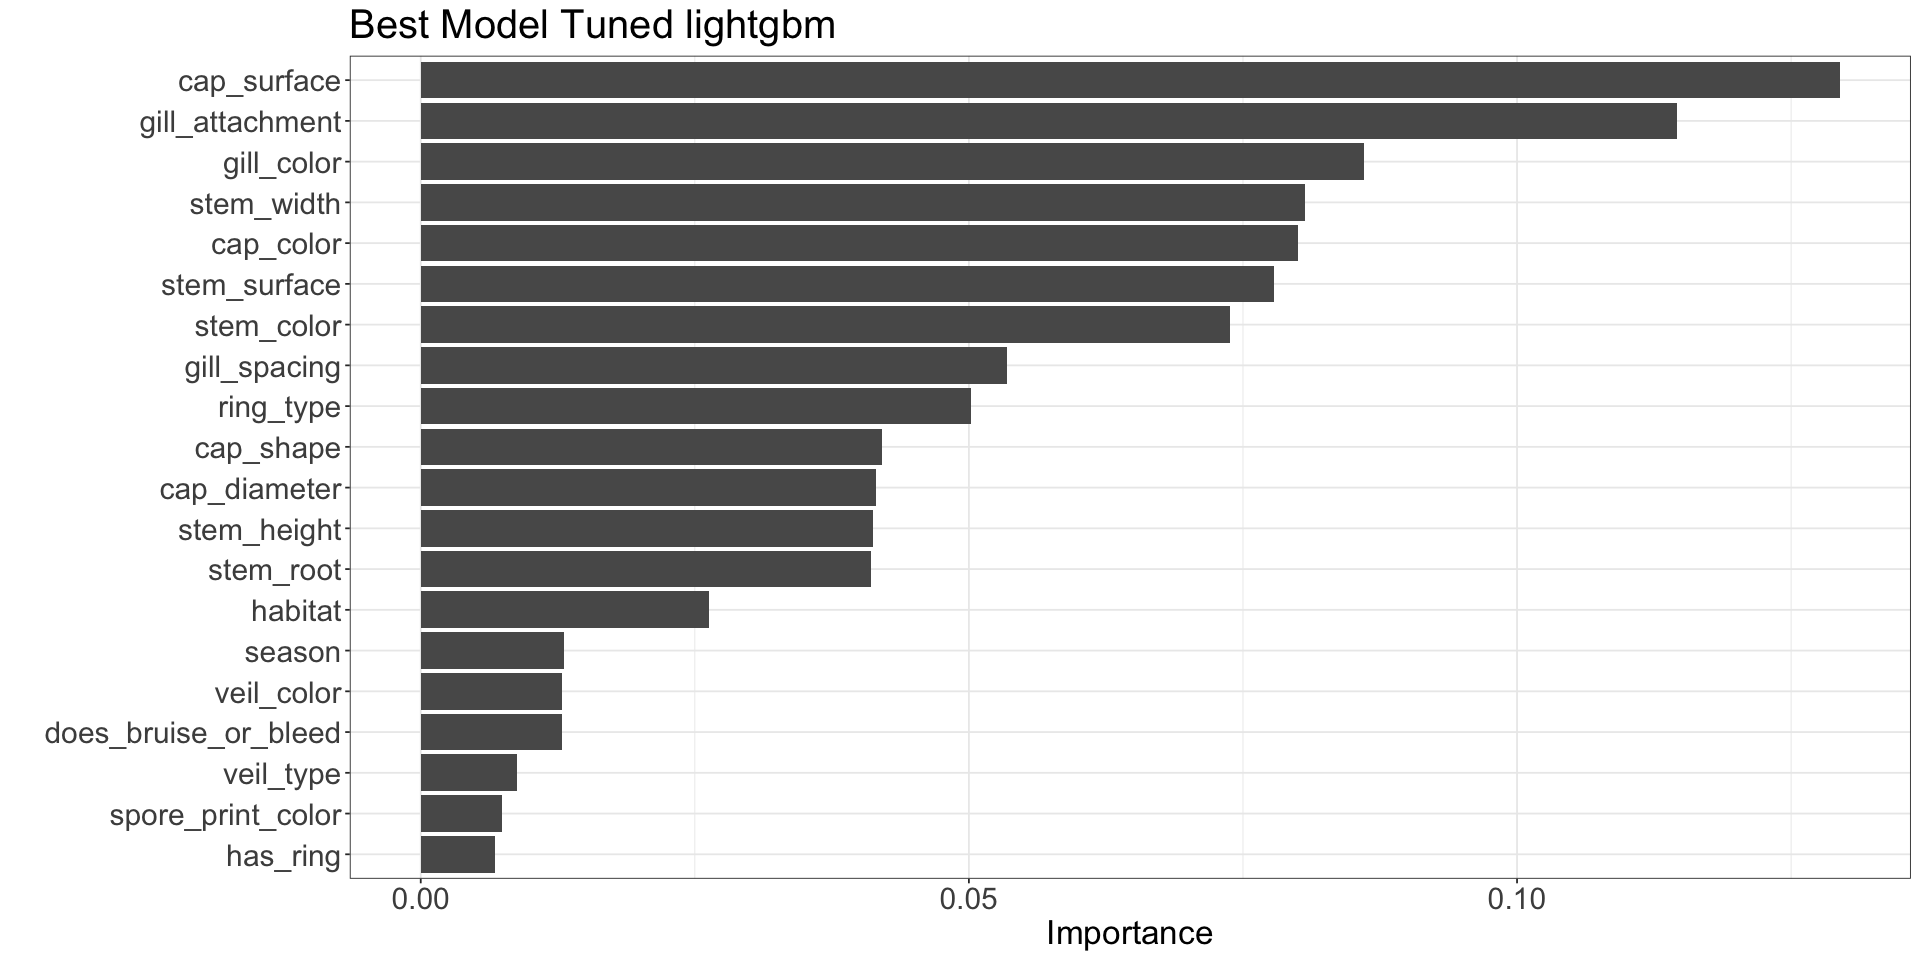

In [31]:
# Variable Importance of best model no encoding 
options(repr.plot.width=16, repr.plot.height=8)
vip_no_encoding <- model_1_tuned %>%
  extract_fit_engine() %>%
  vip(num_features = 22)
vip_no_encoding + ggtitle("Best Model Tuned lightgbm") + my_theme()

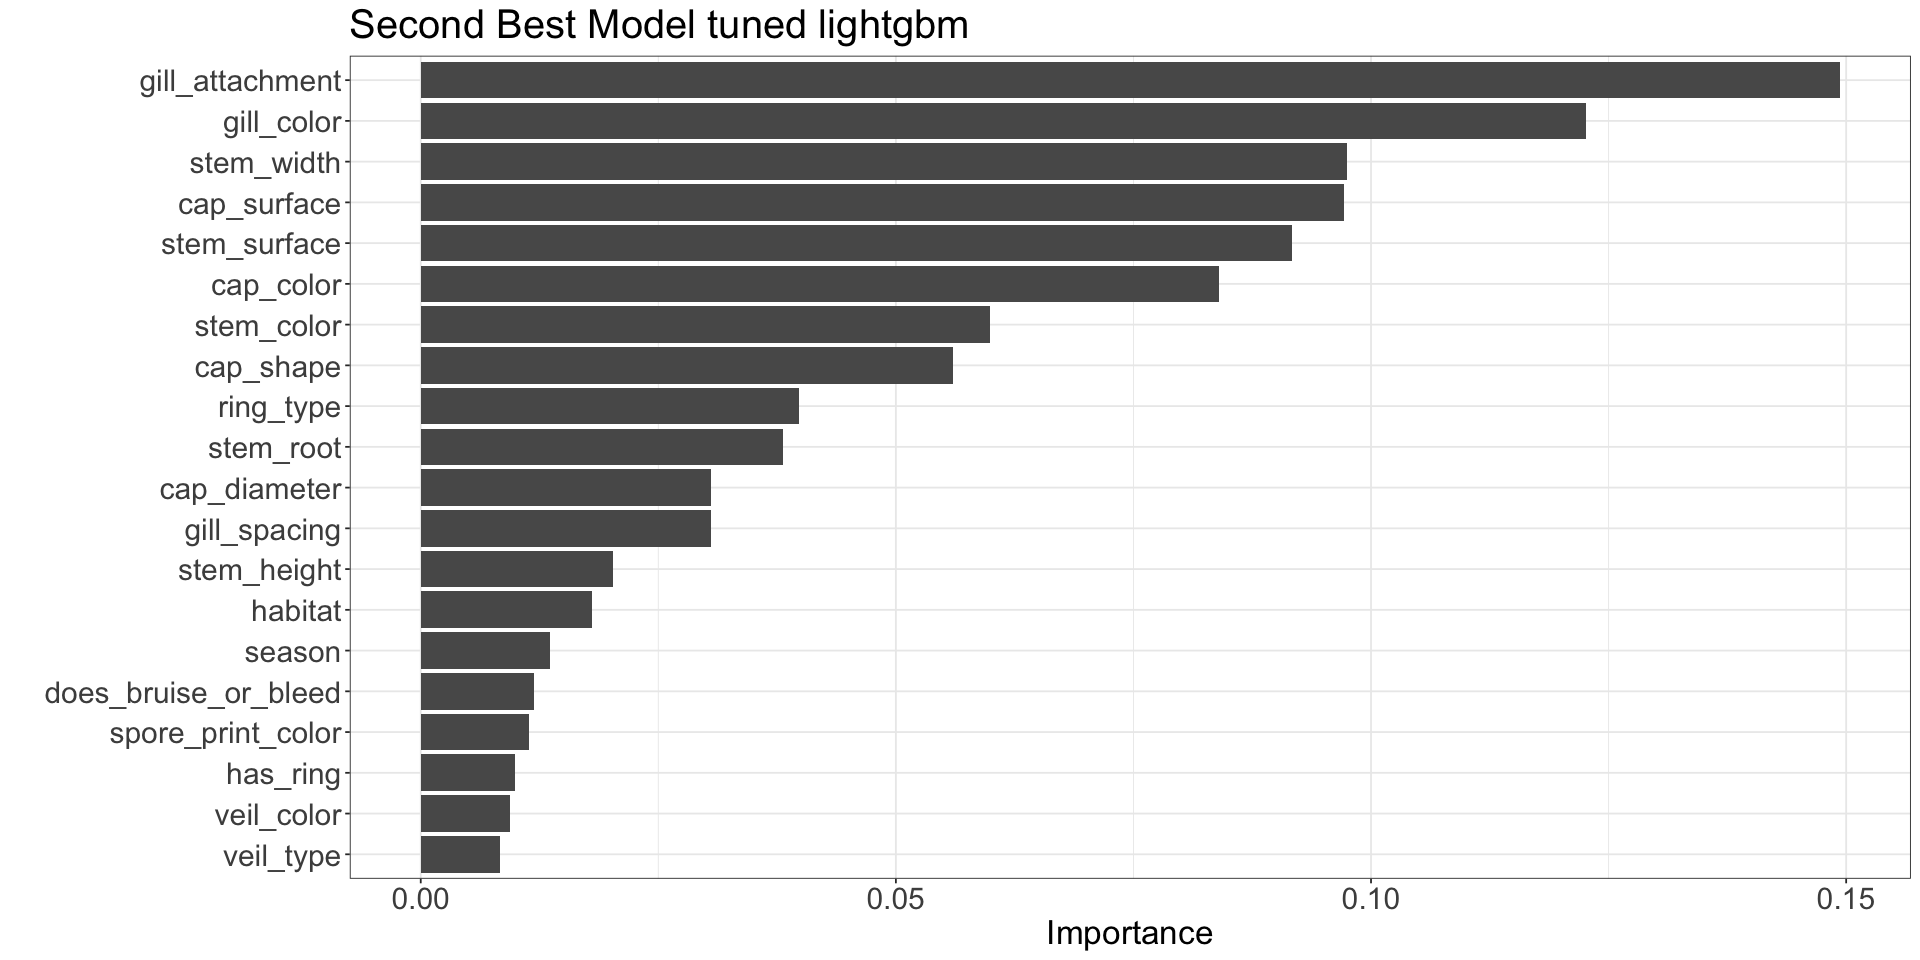

In [32]:
# Variable Importance of best model effect encoding 
vip_no_encoding <- model_2_tuned %>%
  extract_fit_engine() %>%
  vip(num_features = 22)
vip_no_encoding + ggtitle("Second Best Model tuned lightgbm") + my_theme()

# **Submission**

In [33]:
test_ready %>% 
  bind_cols("model_1_preds" = predict(model_1_tuned, test_ready, type = "prob")$.pred_1) %>% 
  bind_cols("model_2_preds" = predict(model_2_tuned, test_ready, type = "prob")$.pred_1)

id,cap_diameter,cap_shape,cap_surface,cap_color,does_bruise_or_bleed,gill_attachment,gill_spacing,gill_color,stem_height,...,stem_color,veil_type,veil_color,has_ring,ring_type,spore_print_color,habitat,season,model_1_preds,model_2_preds
<dbl>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,...,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
3116945,8.64,x,Missing,n,1,Missing,Missing,w,11.13,...,w,u,w,1,g,Missing,d,a,0.0019905761,0.0018182030
3116946,6.90,o,t,o,0,Missing,c,y,1.27,...,n,Missing,Missing,0,f,Missing,d,a,0.9987702591,0.9992407303
3116947,2.00,b,g,n,0,Missing,c,n,6.18,...,n,Missing,Missing,0,f,Missing,d,s,0.9926455466,0.9917972726
3116948,3.47,x,t,n,0,s,c,n,4.98,...,w,Missing,n,1,z,Missing,d,u,0.9936860690,0.9955586296
3116949,6.17,x,h,y,0,p,Missing,y,6.73,...,y,Missing,y,1,Missing,Missing,d,u,0.0011953409,0.0011561213
3116950,4.43,x,h,n,0,x,c,n,5.36,...,n,Missing,Missing,1,r,Missing,d,a,0.0048874919,0.0085704476
3116951,2.92,x,d,n,0,p,Missing,e,4.83,...,y,Missing,Missing,0,f,Missing,d,a,0.0019697722,0.0019551473
3116952,2.59,o,Missing,k,0,f,f,f,2.73,...,g,Missing,Missing,0,f,Missing,d,a,0.9986987046,0.9993252946
3116953,4.13,x,t,o,0,a,c,n,5.36,...,o,Missing,Missing,1,z,Missing,d,w,0.9961516860,0.9964582413


In [35]:
test_out <- test_ready %>% 
  bind_cols("model_1_preds" = predict(model_1_tuned, test_ready, type = "prob")$.pred_1) %>% 
  bind_cols("model_2_preds" = predict(model_2_tuned, test_ready, type = "prob")$.pred_1) %>% 
  mutate_at(vars(ends_with("preds")), standardize_normalize_probs) %>% 
  mutate(ensemble_preds = (model_1_preds + model_1_preds)/2,
        ensemble_preds = if_else(ensemble_preds >= 0.44, 1, 0),
        class = as.character(if_else(ensemble_preds == 1, "p", "e"))) %>% 
  select(id, class, model_1_preds, model_2_preds, ensemble_preds)
test_out %>% head(10)

id,class,model_1_preds,model_2_preds,ensemble_preds
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
3116945,e,0.0019625928,0.0017938318,0
3116946,p,0.9987705410,0.9992454545,1
3116947,p,0.9926456548,0.9918017797,1
3116948,p,0.9936862067,0.9955632463,1
3116949,e,0.0011673350,0.0011317307,0
3116950,e,0.0048595907,0.0085462733,0
3116951,e,0.0019417883,0.0019307801,0
3116952,p,0.9986989845,0.9993300213,1
3116953,p,0.9961518936,0.9964628843,1


In [36]:
test_out %>% 
  select(id, class) %>% 
  write_csv("Data/1_submission.csv")

# **Saving relevant objects**

In [37]:
# Saving workflows that produced models:
relevant_objects <- list(
  tuned_workflows = tuned_workflows,
  model_1_tuned = model_1_tuned,
  model_2_tuned = model_2_tuned
)
saveRDS(relevant_objects, "Data/1_initial_models_submission.rds")
